# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

---

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from time import time

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio

#### Basic Infos:

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print(f'The shape of portfolio data is {portfolio.shape}')
print(f'Null values statistics is: \n{portfolio.isnull().sum()}')
print(f'There are {portfolio.id.nunique()} unique ids.')


The shape of portfolio data is (10, 6)
Null values statistics is: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64
There are 10 unique ids.


In [5]:
print(f"There are the following offer types: \n "
      f"{portfolio.groupby('offer_type').id.count()}")

There are the following offer types: 
 offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


### 2. Profiles

#### Basic Infos:

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**NOTE:** from the `head` we can already see that there are missing values in `income` and `gender`, and `118` seems to represent missing ages.

In [7]:
print(f'The shape of Profile data is {profile.shape}')
print(f'Null values statistics is: \n{profile.isnull().sum()}')
print(f'There are {profile.id.nunique()} unique ids.')

The shape of Profile data is (17000, 5)
Null values statistics is: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
There are 17000 unique ids.


In [8]:
profile_no_age = profile[profile.age==118]

In [9]:
print(f'{profile_no_age.count()}')
profile_no_age.head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


From above we can see that rows without `age` also miss `income` and `gender`, hence, these rows will be dropped in later operations. 

#### Distributions:

In [10]:
print(f"The gender distribution is {profile.groupby('gender').id.count()}")

The gender distribution is gender
F    6129
M    8484
O     212
Name: id, dtype: int64


The Age Histogram


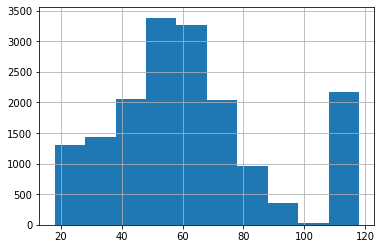

In [11]:
print('The Age Histogram')
profile.age.hist()

The Income Histogram


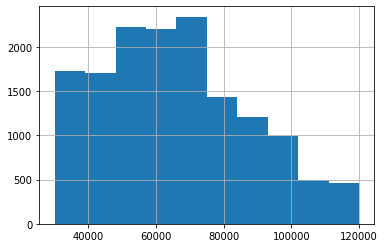

In [12]:
print('The Income Histogram')
profile.income.hist()

### 3. Transcript

#### Basic Infos:

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
print(f'The shape of Transcript data is {transcript.shape}')
print(f'Null values statistics is: \n{transcript.isnull().sum()}')
print(f'There are {transcript.person.nunique()} unique ids.')

The shape of Transcript data is (306534, 4)
Null values statistics is: 
person    0
event     0
value     0
time      0
dtype: int64
There are 17000 unique ids.


#### Distributions

In [15]:
print(f"Event Distribution:\n{transcript.groupby('event').person.count()}")

Event Distribution:
event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64


We need to extract information from the `value` column for further exploration.

In [16]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], 
                       axis=1)

transcript['clean_id'] = np.where(transcript['offer id'].isnull() & 
                                  transcript['offer_id'].notnull(), 
                                  transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [17]:
print(f'There are {transcript.offer_id.nunique()} unique offers')

There are 10 unique offers


---

## Preprocessing

### 1. Merge `portfolio` and `transcript`

In [18]:
pf_ts_merge = transcript.merge(portfolio,
                               how='left',
                               left_on='offer_id',
                               right_on='id')

pf_ts_merge.sort_values(['person', 'time'], inplace=True)

pf_ts_merge.head(10)

,person,event,value,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type,id
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d
168412,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4


In [19]:
print(f"Offer Type Distribution on Event:\n"
      f"{pf_ts_merge.groupby(['event', 'offer_type'])['offer_type'].count()}")

Offer Type Distribution on Event:
event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64


**NOTE:** In the datasets, `offer_id` is not linked to `transaction` event, so we will need to link transactions to events.

`bogo` and `discount` are more straightforward in terms of causing transactions, hence easier to track transactions after offer received, viewed and completed. 

However, we should also pay adequate attention to `informational` offers, thought they are indirect to be linked with transactions.


In [20]:
offer_completed = pf_ts_merge[(pf_ts_merge['event']=='transaction') |
                              (pf_ts_merge['event']=='offer_viewed')] \
                             [['time', 'offer_id', 'person', 'event']]

offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

offer_completed.head(10)

,time,offer_id,person,event
89291,228,NaN,0009655768c64bdeb2e877511632db8f,transaction
168412,414,NaN,0009655768c64bdeb2e877511632db8f,transaction
228422,528,NaN,0009655768c64bdeb2e877511632db8f,transaction
237784,552,NaN,0009655768c64bdeb2e877511632db8f,transaction
258883,576,NaN,0009655768c64bdeb2e877511632db8f,transaction
293497,660,NaN,0009655768c64bdeb2e877511632db8f,transaction
300930,690,NaN,0009655768c64bdeb2e877511632db8f,transaction
302205,696,NaN,0009655768c64bdeb2e877511632db8f,transaction
104088,294,NaN,00116118485d4dfda04fdbaba9a87b5c,transaction
187632,456,NaN,00116118485d4dfda04fdbaba9a87b5c,transaction


In [21]:
pf_ts_merge = pf_ts_merge.merge(offer_completed,
                                how='left',
                                on=['person', 'time', 'event'])

pf_ts_merge.head()

,person,event,value,time,amount,reward_x,offer_id_x,reward_y,channels,difficulty,duration,offer_type,id,offer_id_y
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,NaN


In [22]:
pf_ts_merge['offer_id'] = np.where(pf_ts_merge['offer_id_x'].isnull(),
                                   pf_ts_merge['offer_id_y'],
                                   pf_ts_merge['offer_id_x'])

pf_ts_merge.drop(columns=['offer_id_x', 'offer_id_y', 'reward_x', 'reward_y'],
                 axis=1, inplace=True)

pf_ts_merge.head(10)

,person,event,value,time,amount,channels,difficulty,duration,offer_type,id,offer_id
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed
5,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d
6,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,8.57,NaN,NaN,NaN,NaN,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d
8,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d
9,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4


In [23]:
pf_ts_merge = pf_ts_merge.merge(portfolio,
                                how='left',
                                left_on='offer_id',
                                right_on='id')

In [26]:
pf_ts_merge['duration'] = np.where(pf_ts_merge['duration_x'].isnull(),
                                   pf_ts_merge['duration_y'],
                                   pf_ts_merge['duration_x'])

pf_ts_merge.drop(columns=['duration_x', 'duration_y',
                          'difficulty_x', 'channels_x',
                          'offer_type_x'],
                 axis=1, inplace=True)

pf_ts_merge.rename(columns={'channels_y': 'channels',
                            'reward_y': 'reward',
                            'difficulty_y': 'difficulty',
                            'offer_type_y': 'offer_type'},
                   inplace=True)

pf_ts_merge.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,informational,3f207df678b143eea3cee63160fa8bed,4.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,informational,3f207df678b143eea3cee63160fa8bed,4.0


In [27]:
transactions_after_viewed = \
    pf_ts_merge[(pf_ts_merge['event']=='offer viewed') |
                (pf_ts_merge['event']=='transaction') |
                (pf_ts_merge['event']=='offer completed')].copy()

transactions_after_viewed['pre_offer_id'] = \
    transactions_after_viewed.groupby(['person', 'offer_id']) \
        ['offer_id'].shift()

transactions_after_viewed['completed_offer'] = \
    np.where(transactions_after_viewed['pre_offer_id']== \
             transactions_after_viewed['offer_id'], 1, 0)

transactions_after_viewed.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,pre_offer_id,completed_offer
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,0
6,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0
